# Recitation 1: More about MIMIC

MIMIC-III is the largest publically available clinical dataset.

Here we seek to do two exploratory tasks:

1) Plot age distribution at admissions.

2) Plot heart rates. Then heart rates by age.

In [1]:
import datetime
import numpy as np

import pandas as pd
import psycopg2


%matplotlib inline
from matplotlib import pyplot as plt

def clean_plot():
    ax = plt.subplot(111) 
    ax.spines["top"].set_visible(False) 
    ax.spines["bottom"].set_visible(False) 
    ax.spines["right"].set_visible(False) 
    ax.spines["left"].set_visible(False) 
    ax.grid()
    ax.get_xaxis().tick_bottom() 
    ax.get_yaxis().tick_left() 

/afs/csail.mit.edu/u/i/iychen/.local/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
sqluser = 'iychen'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

query = \
"""
select 
   subject_id, dob
from patients
"""

patients_df = pd.read_sql_query(query,con)
print len(patients_df)

query = \
"""
select
   subject_id, admittime, insurance
from admissions
"""

admissions_df = pd.read_sql_query(query, con)
print len(admissions_df)

46520
58976


In [3]:
df = admissions_df.merge(patients_df, on='subject_id', how='left')

In [4]:
def get_age(dob, admittime):
    diff = (admittime - dob).total_seconds() / (3600 * 24 * 365.25)
    return diff

In [5]:
df['age'] = df.apply(lambda x: get_age(x['dob'], x['admittime']), axis=1)

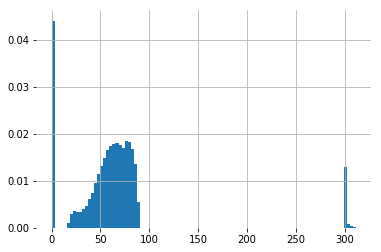

In [6]:
plt.hist(df['age'], bins=100, normed=True)
clean_plot()
plt.show()

In [7]:
df['insurance'].value_counts()

Medicare      28215
Private       22582
Medicaid       5785
Government     1783
Self Pay        611
Name: insurance, dtype: int64

In [8]:
query = \
"""
select * from chartevents 
where itemid in (211, 220045) and valuenum is not null
"""

hrt_df = pd.read_sql_query(query,con)
print len(hrt_df)



7941588


In [9]:
hrt_df.head()

,row_id,subject_id,hadm_id,icustay_id,itemid,charttime,storetime,cgid,value,valuenum,valueuom,warning,error,resultstatus,stopped
0,34308324,3,145834,211552.0,211,2101-10-25 04:00:00,2101-10-25 04:05:00,16302.0,88,88.0,BPM,NaN,NaN,None,NotStopd
1,34309374,4,185777,294638.0,211,2191-03-16 08:00:00,2191-03-16 09:16:00,18692.0,80,80.0,BPM,NaN,NaN,None,NotStopd
2,34310442,6,107064,228232.0,211,2175-05-31 02:00:00,2175-05-31 02:16:00,15443.0,79,79.0,BPM,NaN,NaN,None,NotStopd
3,34335403,13,143045,263738.0,211,2167-01-11 04:55:00,2167-01-11 05:17:00,20971.0,98,98.0,BPM,NaN,NaN,None,NotStopd
4,34335430,13,143045,263738.0,211,2167-01-11 05:00:00,2167-01-11 04:43:00,20971.0,82,82.0,BPM,NaN,NaN,None,NotStopd


In [10]:
hrt_df['system'] = hrt_df['itemid'].apply(lambda x: 'Carevue' if x == 211 else 'Metavision')

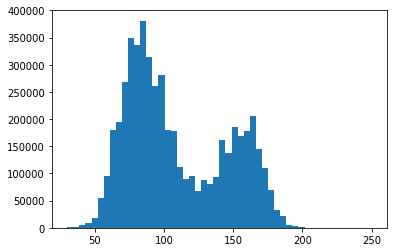

In [11]:
c_values = hrt_df[hrt_df['system'] == 'Carevue']['value'].astype(float)
c_values = [i for i in c_values if not np.isnan(i)]
c_values = [i for i in c_values if i <= 250 and i >= 30]
plt.hist(c_values,bins=50)
plt.show()

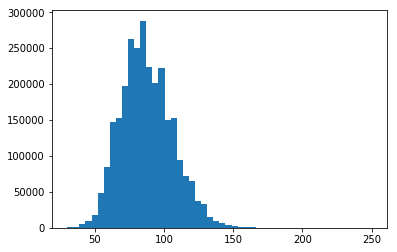

In [12]:
m_values = hrt_df[hrt_df['system'] == 'Metavision']['value'].astype(float)
m_values = [i for i in m_values if not np.isnan(i)]
m_values = [i for i in m_values if i <= 250 and i >= 30]
plt.hist(m_values, bins=50)
plt.show()

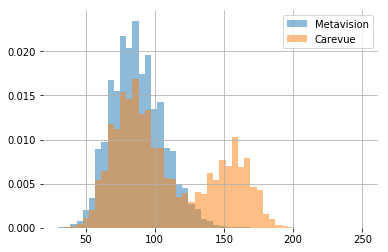

In [13]:
plt.hist(m_values, normed=True, bins=np.linspace(30,250,50),alpha=0.5, label='Metavision')
plt.hist(c_values, normed=True, bins=np.linspace(30,250,50),alpha=0.5, label='Carevue')
plt.legend()
clean_plot()
plt.show()

What about heart rates by ages?

In [14]:
df2 = hrt_df.merge(patients_df, on='subject_id', how='left')

In [15]:
print len(df2)

7941588


In [25]:
df3 = df2.groupby('subject_id', as_index=False).first()
print len(df3)

45988


In [34]:
df3['age'] = df3.apply(lambda x: get_age(x['dob'], x['charttime']), axis=1)

df3['value'] = df3['value'].astype(float)

In [35]:
print np.max(df3['age']), np.min(df3['age'])
print np.max(df3['value']), np.min(df3['value'])

310.2785763175907 0.0
204.0 30.0


In [37]:
df3 = df3[(df3['age'] >= 0) & (df3['age'] < 400)]
df3 = df3[(df3['value'] >= 30) & (df3['value'] <= 250)]

In [38]:
print len(df3)

45795


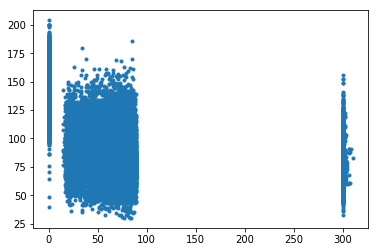

In [39]:
plt.plot(df3['age'], df3['value'], '.')

# Logistic Regression

We want to demonstrate how to run a logistic regression on a toy problem: predicting death from other admissions quantities.

Note that we don't differentiate out types of death (in hopsital, in-ICU) and we are only using admissions numbers.

In [44]:
query = \
"""
select 
   *
from patients
"""

patients_df = pd.read_sql_query(query,con)
print len(patients_df)

46520


In [ ]:
admissions_df

In [49]:
query = \
"""
select
   *
from admissions
"""

admissions_df = pd.read_sql_query(query, con)
print len(admissions_df)

58976


In [54]:
admissions_df['hospital_expire_flag'].mean()

0.09926071622354857

In [98]:
X1 = pd.get_dummies(admissions_df['admission_type'], prefix='adm')
X2 = pd.get_dummies(admissions_df['admission_location'],prefix='loc')
X3 = pd.get_dummies(admissions_df['insurance'], prefix='insur')
X4 = pd.get_dummies(admissions_df['marital_status'], prefix='marital')

In [99]:
X = pd.concat([X1, X2, X3, X4], axis=1)
y = admissions_df['hospital_expire_flag']

In [100]:
print X.shape
print y.shape

(58976, 25)
(58976,)


In [102]:
clf = LogisticRegression()

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7)

In [104]:
clf.fit(X_train,y_train)
print clf.score(X_test,y_test)

0.90069519018821


In [105]:
y_probs = clf.predict_proba(X_test)[:,1]

In [106]:
print roc_auc_score(y_test, y_probs)

0.6966738789249199


In [108]:
for i,j in sorted(zip(X.columns,clf.coef_[0]), key=lambda x: x[1]):
    print i,j

adm_NEWBORN -2.362588072315625
marital_SINGLE -1.1263287531918926
marital_LIFE PARTNER -1.0335357846593487
marital_DIVORCED -0.883965570562124
marital_MARRIED -0.7965596873557327
marital_SEPARATED -0.7601818007072149
insur_Government -0.73249373071663
marital_WIDOWED -0.6846488546143337
loc_PHYS REFERRAL/NORMAL DELI -0.6366554885217509
adm_ELECTIVE -0.5719963557598011
loc_CLINIC REFERRAL/PREMATURE -0.5153404673007015
insur_Medicaid -0.46347966621285563
insur_Private -0.4594082219285568
loc_TRSF WITHIN THIS FACILITY -0.4132519712387847
marital_UNKNOWN (DEFAULT) -0.34160504626592353
loc_EMERGENCY ROOM ADMIT -0.33443265315165105
loc_TRANSFER FROM HOSP/EXTRAM -0.3264593259041748
loc_TRANSFER FROM OTHER HEALT -0.107928938471283
loc_TRANSFER FROM SKILLED NUR 0.07117429834907459
insur_Medicare 0.073442779364
insur_Self Pay 0.14290015020296432
loc_** INFO NOT AVAILABLE ** 0.14414603595626907
adm_URGENT 0.6518055888445157
loc_HMO REFERRAL/SICK 0.6797098210849573
adm_EMERGENCY 0.8437401497812353